# Stock Prices Paths Simulation

In [23]:
import numpy as np
import pandas as pd
from datetime import datetime
from IPython.display import display
from yahoo_fin import options
from yahoo_fin import stock_info as si
import matplotlib.pyplot as plt

import functions.BlackScholes as bs
import functions.Merton as m
import functions.Kou as k
import functions.VarianceGamma as vg

np.random.seed(27)

### Get Option Data

In [24]:
symbol = 'META'  # AAPL, TSLA, MSFT, META, CAT, STM, GOOG, NFLX, AMZN
dates = options.get_expiration_dates(symbol)
# print(dates)

T_str = 'June 21, 2024'  # This is the first "greater than a year" expiry date
calls = options.get_calls(symbol, T_str)
puts = options.get_puts(symbol, T_str)

T_datetime = datetime.strptime(T_str, '%B %d, %Y')
ttm = (T_datetime - datetime.now()).days / 365.0  # to use the time to maturity in float mode

calls['Time-to-maturity'] = ttm
puts['Time-to-maturity'] = ttm
# display(calls.columns)
print(calls.head())

         Contract Name         Last Trade Date  Strike  Last Price     Bid   
0  META240621C00005000   2023-06-14 1:23PM EDT     5.0      266.70  279.50  \
1  META240621C00010000   2023-02-27 3:36PM EDT    10.0      160.70  194.00   
2  META240621C00015000   2023-06-15 9:30AM EDT    15.0      258.27  270.00   
3  META240621C00020000  2023-02-28 11:10AM EDT    20.0      157.30  187.85   
4  META240621C00025000   2023-06-15 9:30AM EDT    25.0      248.78  260.60   

      Ask  Change % Change Volume  Open Interest Implied Volatility   
0  283.25     0.0        -      1              0            198.34%  \
1  197.90     0.0        -      4             11              0.00%   
2  273.05     0.0        -      2              0            143.16%   
3  189.75     0.0        -      2             26              0.00%   
4  264.30     0.0        -      2              0            138.53%   

   Time-to-maturity  
0          0.964384  
1          0.964384  
2          0.964384  
3          0.964

#### Find historic volatility

In [25]:
# historic volatility
stock_data = si.get_data(symbol, start_date='31/05/2021', end_date='31/05/2023')
# print(stock_data.head())
stock_data['Returns'] = stock_data['close'] / stock_data['close'].shift()
stock_data['Log Returns'] = np.log(stock_data['Returns'])
print(stock_data.head())
volatility = stock_data['Log Returns'].std() * np.sqrt(252)
print(f'\nHistorical volatility: {round(volatility, 3)}')

                  open        high         low       close    adjclose   
2021-06-01  330.149994  331.420013  326.640015  329.130005  329.130005  \
2021-06-02  330.380005  331.869995  327.119995  329.149994  329.149994   
2021-06-03  325.779999  327.380005  323.480011  326.040009  326.040009   
2021-06-04  325.899994  332.459991  325.179993  330.350006  330.350006   
2021-06-07  329.480011  337.690002  328.929993  336.579987  336.579987   

              volume ticker   Returns  Log Returns  
2021-06-01  11765900   META       NaN          NaN  
2021-06-02  11654300   META  1.000061     0.000061  
2021-06-03  12610800   META  0.990551    -0.009493  
2021-06-04  13289400   META  1.013219     0.013133  
2021-06-07  20136700   META  1.018859     0.018683  

Historical volatility: 0.549


### Data preparation

In [26]:
# convert the 'Implied Volatility' column to a numeric type
calls['Implied Volatility'] = pd.to_numeric(calls['Implied Volatility'].str.strip('%')) / 100
puts['Implied Volatility'] = pd.to_numeric(puts['Implied Volatility'].str.strip('%')) / 100
# choose one option as starting point
option = calls.iloc[np.random.randint(len(calls))]
print(option)

Contract Name            META240621C00100000
Last Trade Date       2023-06-26 12:25PM EDT
Strike                                 100.0
Last Price                             186.0
Bid                                    190.1
Ask                                   193.15
Change                                   0.0
% Change                                   -
Volume                                     3
Open Interest                              0
Implied Volatility                    0.8098
Time-to-maturity                    0.964384
Name: 19, dtype: object


#### Fix simulation parameters

In [27]:
# FIXED PARAMETERS (used for all models)
S0 = si.get_live_price(symbol)  # get live price of stock
print(f'{symbol} Current stock price: {round(S0, 2)}')
T = ttm  # Expiry Date in years
days = 252
paths = 1000
K = option[2]  # Strike price
sigma = volatility
r = 0.05  # risk.free interest rate
size = (days, paths)

META Current stock price: 286.02


### Black and Scholes model

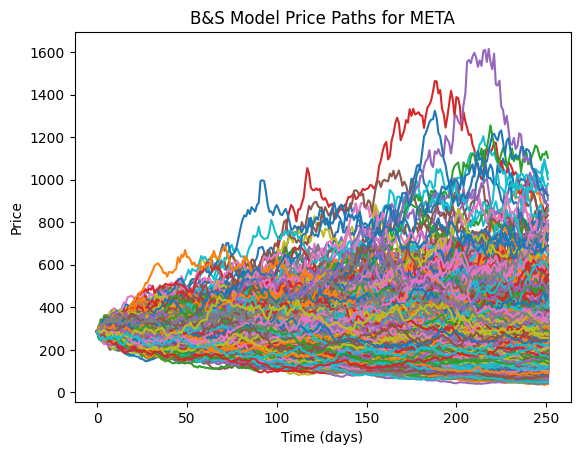

<Figure size 1000x600 with 0 Axes>

In [28]:
SBlackScholes = bs.BlackScholesPath(T, days, paths, sigma, r, S0)
bs.plotBSPath(SBlackScholes, symbol)  # Plot all paths

#### Plot a subset of 5 paths

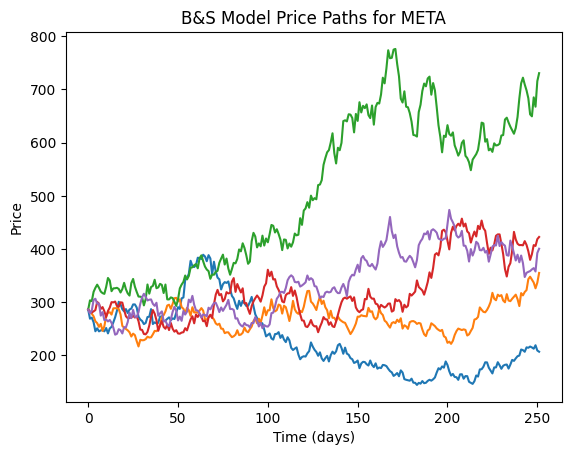

<Figure size 1000x600 with 0 Axes>

In [29]:
subset = 5  # Plot a subset of 5
SBS_subset = np.empty((subset, days))
random_indices = np.random.choice(paths, size=subset)
for path in range(subset):
    SBS_subset[path] = SBlackScholes[:, random_indices[path]]
bs.plotBSPath(SBS_subset.T, symbol)

#### Plot only one random path

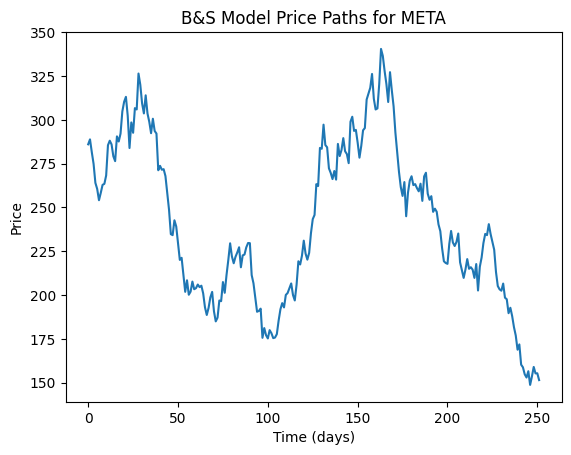

<Figure size 1000x600 with 0 Axes>

In [30]:
bs.plotBSPath(SBlackScholes[:, np.random.choice(paths)], symbol)  # Plot only one

### Merton Jump Diffusion model

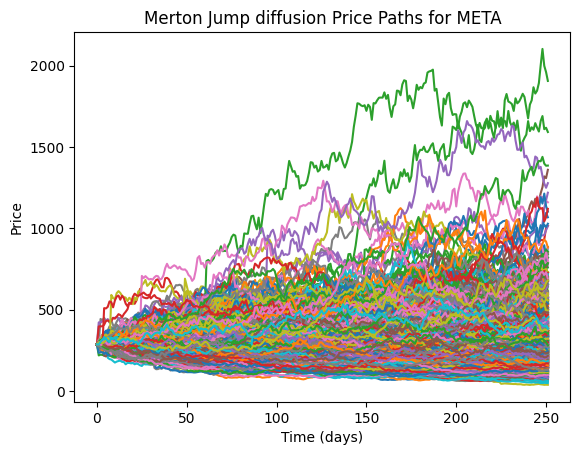

<Figure size 1000x600 with 0 Axes>

In [31]:
lamda = 0.5
jump_mean = 0
jump_std = 0.2
SMerton = m.MertonPath(T, days, paths, sigma, r, lamda, jump_mean, jump_std, S0)

m.plotMertonPath(SMerton, symbol)  # Plot all paths

#### Plot a subset of 5 paths

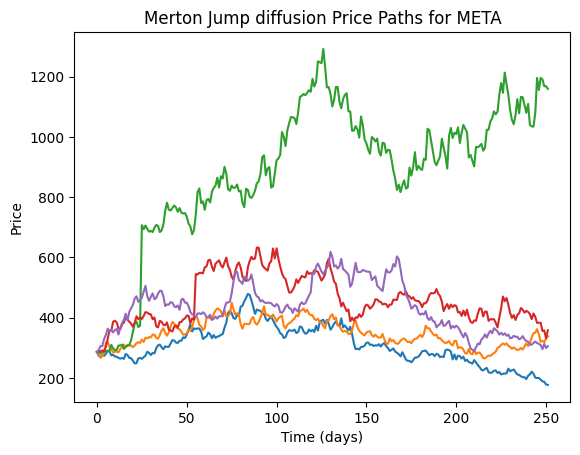

<Figure size 1000x600 with 0 Axes>

In [32]:
subset = 5  # Plot a subset of 5
SM_subset = np.empty((subset, days))
random_indices = np.random.choice(paths, size=subset)
for path in range(subset):
    SM_subset[path] = SMerton[:, random_indices[path]]
m.plotMertonPath(SM_subset.T, symbol)


#### Plot only one random path

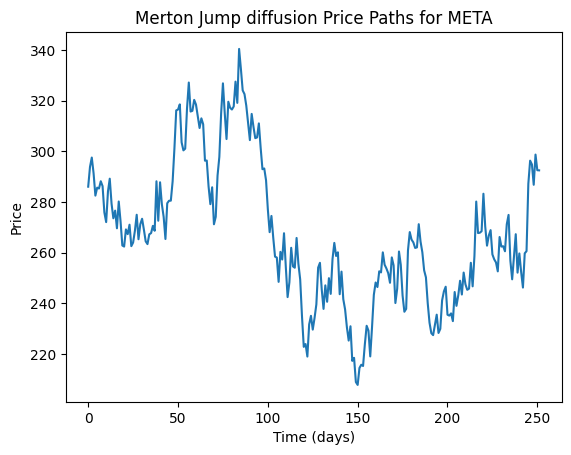

<Figure size 1000x600 with 0 Axes>

In [33]:
m.plotMertonPath(SMerton[:, np.random.choice(paths)], symbol)  # Plot only one

### Kou Jump Diffusion Model

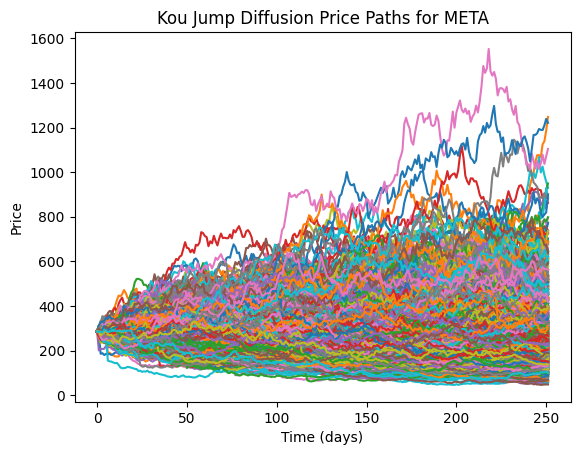

<Figure size 1000x600 with 0 Axes>

In [34]:
eta_1 = 10  # upward jump magnitude
eta_2 = 2  # downward jump
p = 0.4  # q = 0.6
SKou = k.KouPath(T, days, paths, sigma, r, lamda, p, eta_1, eta_2, S0)

# Plot all paths
k.plotKouPath(SKou, symbol)

#### Plot a subset of 5 paths

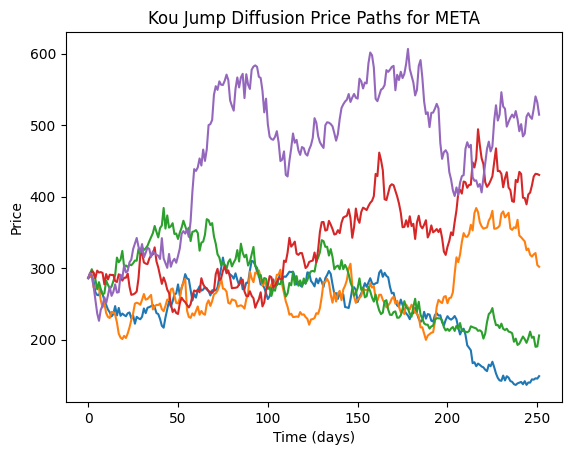

<Figure size 1000x600 with 0 Axes>

In [35]:
# Plot a subset of 5
subset = 5
SK_subset = np.empty((subset, days))
random_indices = np.random.choice(paths, size=subset)
for path in range(subset):
    SK_subset[path] = SKou[:, random_indices[path]]
k.plotKouPath(SK_subset.T, symbol)

#### Plot only one random path

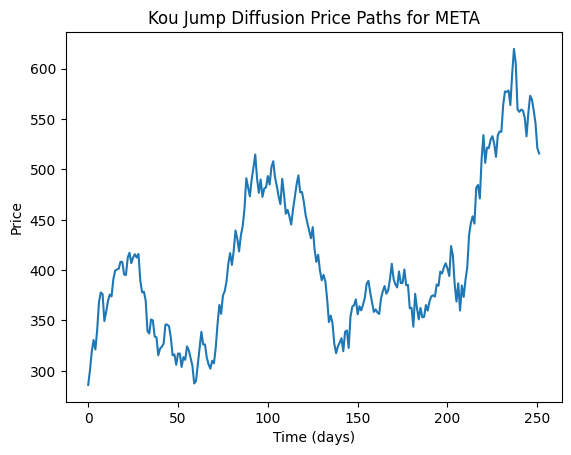

<Figure size 1000x600 with 0 Axes>

In [36]:
# Plot only one
k.plotKouPath(SKou[:, np.random.choice(paths)], symbol)

### Variance Gamma Model

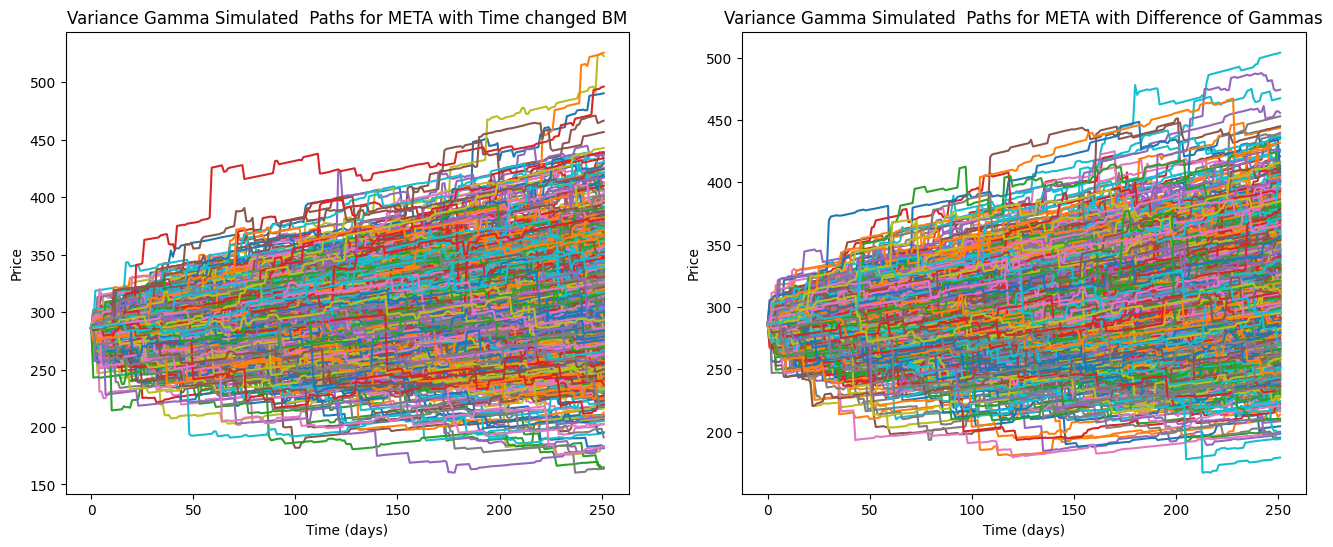

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

In [37]:
theta = -0.15
nu = 0.1
SVarGamma = vg.VarianceGammaPath1(T, days, paths, 0.15, 0.1, nu, theta, S0)
SVarGamma2 = vg.VarianceGammaPath2(T, days, paths, 0.15, 0.1, nu, theta, S0)

method = ['Time changed BM', 'Difference of Gammas']

# Plot all paths
fig1, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
vg.plotVGPath(SVarGamma, symbol, method[0], ax=axes[0])
vg.plotVGPath(SVarGamma2, symbol, method[1], ax=axes[1])
plt.tight_layout()

#### Plot a subset of 5 paths

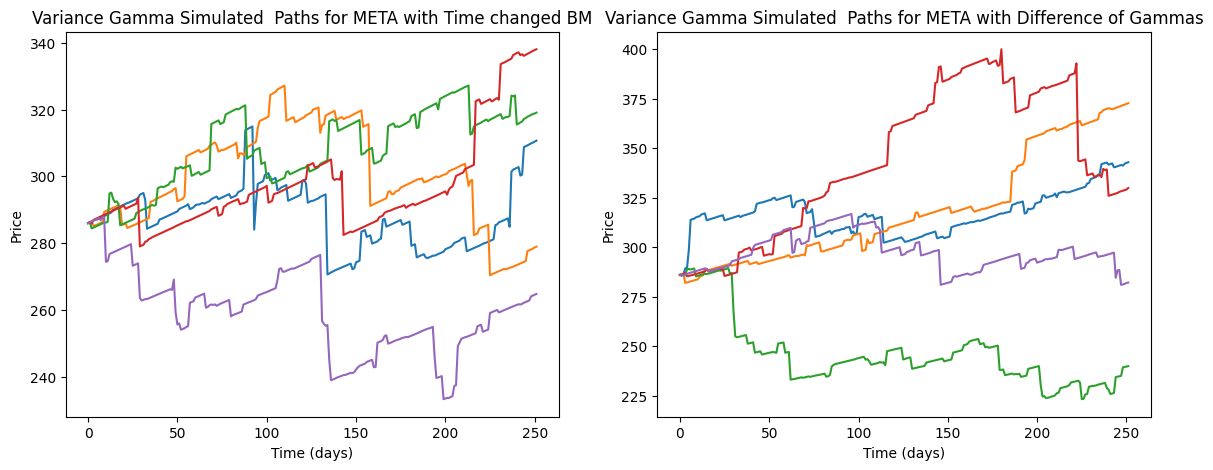

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

In [38]:
fig2, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,5))

subset = 5  # Plot a subset of 5
SVG_subset = np.empty((subset, days))
random_indices = np.random.choice(paths, size=subset)
for path in range(subset):
    SVG_subset[path] = SVarGamma[:, random_indices[path]]
vg.plotVGPath(SVG_subset.T, symbol, method[0], ax=axes[0])

subset = 5
SVG_subset = np.empty((subset, days))
random_indices = np.random.choice(paths, size=subset)
for path in range(subset):
    SVG_subset[path] = SVarGamma2[:, random_indices[path]]
vg.plotVGPath(SVG_subset.T, symbol, method[1], ax=axes[1])

#### Plot only one random path

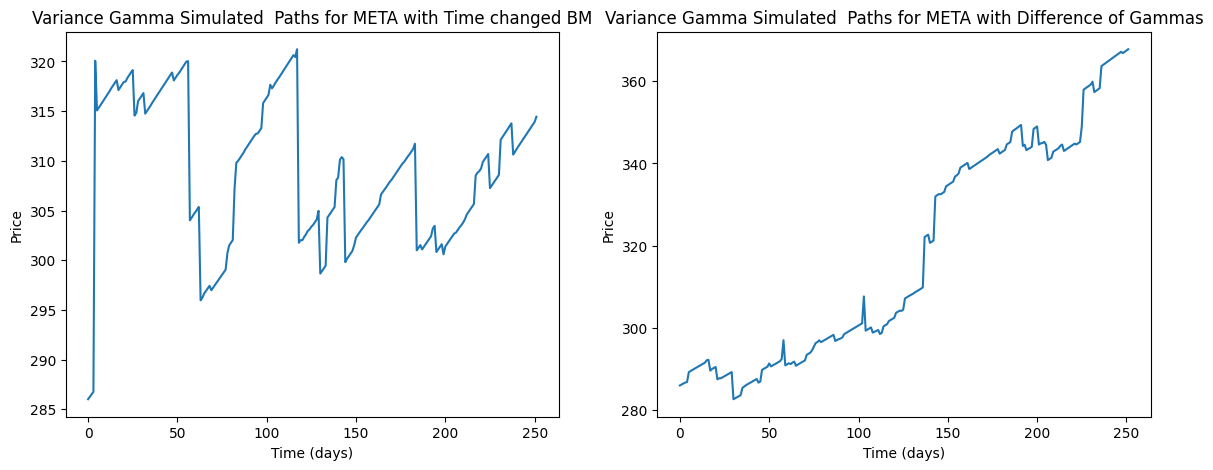

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

In [39]:
# Plot only one
fig3, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
vg.plotVGPath(SVarGamma[:, np.random.choice(paths)], symbol, method[0], ax=axes[0])
vg.plotVGPath(SVarGamma[:, np.random.choice(paths)], symbol, method[1], ax=axes[1])
plt.tight_layout()

#### From Seneta 2004, moments method

In [40]:
# Estimate params of VG (ref. Seneta 2004)
sigma_est = np.sqrt(vg.find_moment(2, theta, nu, sigma))
theta_est = sigma*(vg.find_moment(3,theta, nu, sigma))/(3*nu)
nu_est = (vg.find_moment(4, theta, nu, sigma)/3) - 1

print(f'Variance Gamma Estimated Params\n\t\tSTART\tEXT')
print(f'Sigma:  {round(sigma,2)} -> {round(sigma_est,4)}')
print(f'Theta: {theta} -> {round(theta_est,4)}')
print(f'Nu:     {nu} -> {round(nu_est,4)}')

Variance Gamma Estimated Params
		START	EXT
Sigma:  0.55 -> 0.1459
Theta: -0.15 -> -0.0017
Nu:     0.1 -> -0.9996


### Visualize distributions
#### Distribution of prices

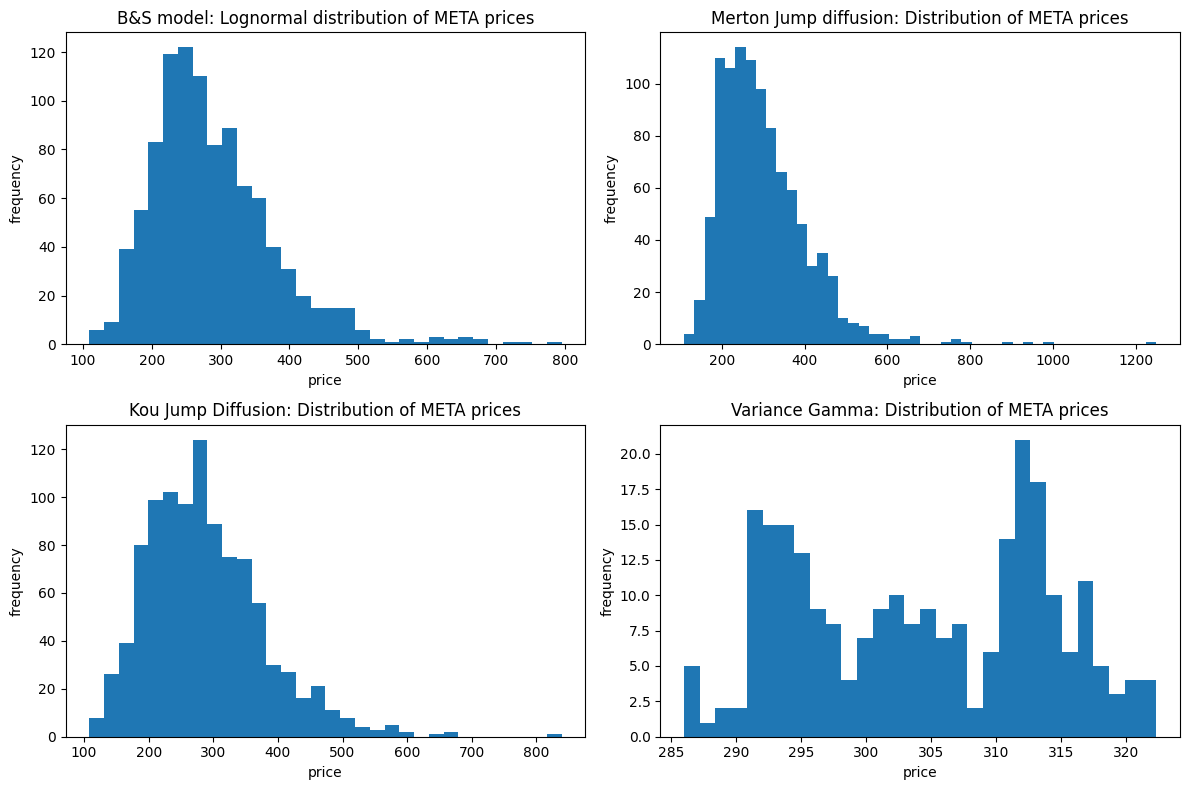

In [41]:
# %%%%%%%%%%%%%%%%%%%%%%%%    Visualize distributions  %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# Average prices
fig4, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
bs.plotBSDist(SBlackScholes, symbol, ax = axes[0,0])
m.plotMertonDist(SMerton, symbol, ax = axes[0,1])
k.plotKouDist(SKou, symbol, ax = axes[1,0])
vg.plotVGDist(SVG_subset, symbol, ax = axes[1,1])
plt.tight_layout()
plt.show()

#### Cumulative distribution of Log returns

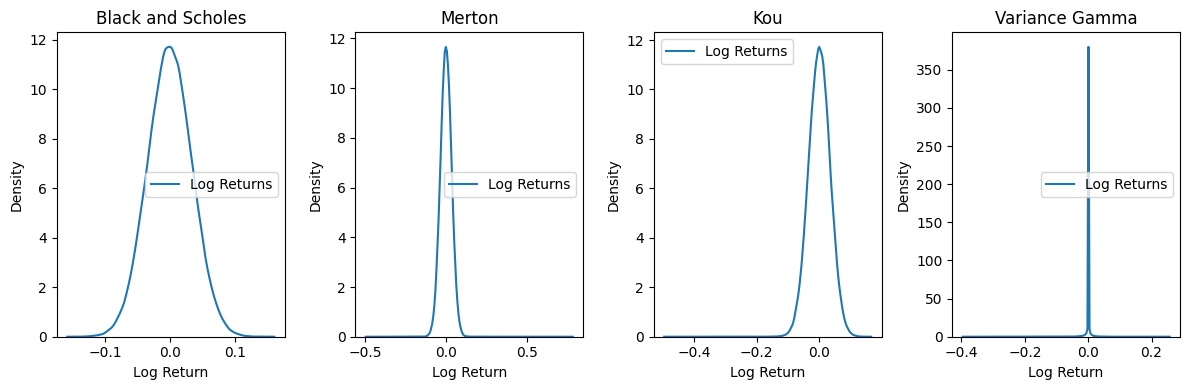

In [42]:
# Log returns ALL PATHS
fig5, axes5 = plt.subplots(nrows=1, ncols=4, figsize=(12,4))
bs.plotBSLogReturns(SBlackScholes, symbol, ax=axes5[0])
m.plotMertonLogReturns(SMerton, symbol, ax=axes5[1])
k.plotKouLogReturns(SKou, symbol, ax=axes5[2])
vg.plotVGLogReturns(SVarGamma2, symbol, ax=axes5[3])
plt.tight_layout()

#### Distribution of Log Returns of a Sampled Path

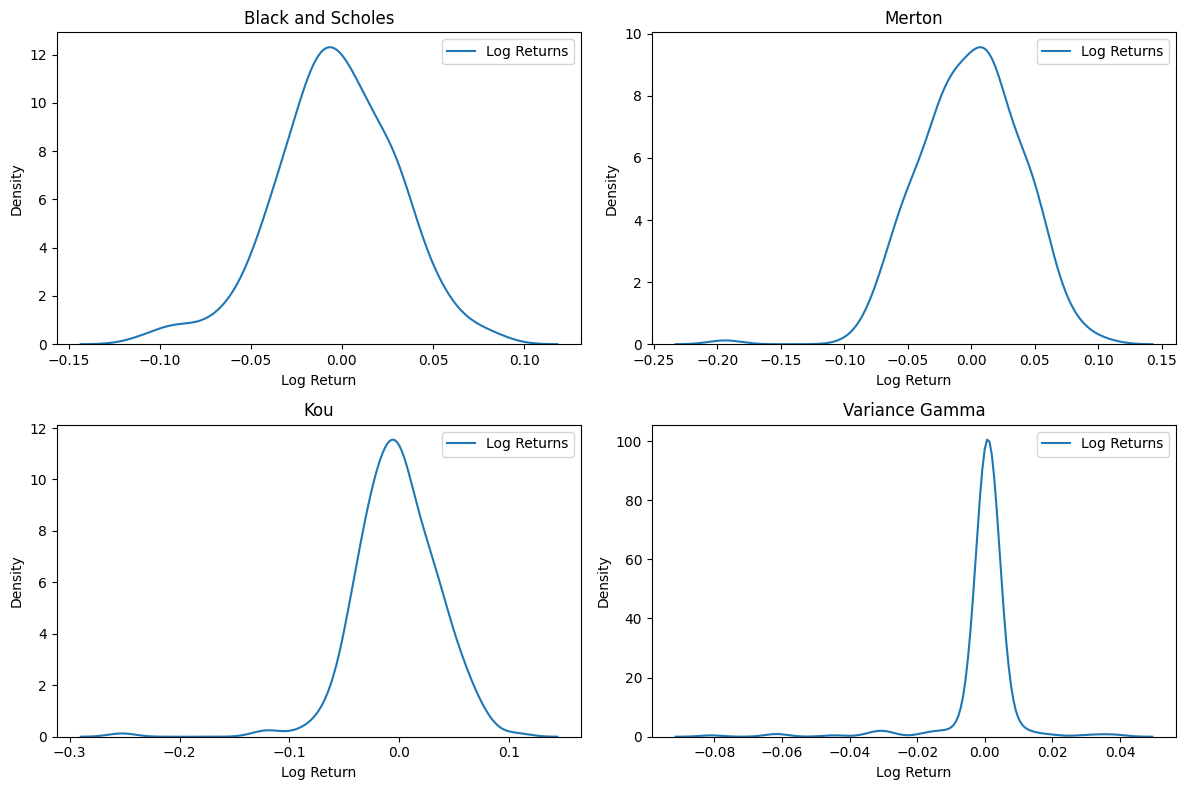

In [43]:
# Log returns ONE RANDOM
fig6, axes6 = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
bs.plotBSLogReturns(SBlackScholes[:, np.random.choice(paths)], symbol, axes6[0,0])
m.plotMertonLogReturns(SMerton[:, np.random.choice(paths)], symbol, axes6[0,1])
k.plotKouLogReturns(SKou[:, np.random.choice(paths)], symbol, axes6[1,0])
vg.plotVGLogReturns(SVarGamma2[:, np.random.choice(paths)], symbol, axes6[1,1])
plt.tight_layout()
